# 02 — Model

In [1]:
# Baseline v2 : ajoute les features issues d'application_train
from pathlib import Path
import numpy as np, pandas as pd, json
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, roc_auc_score, average_precision_score

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT / "data" / "processed"
CFG  = ROOT / "config"; CFG.mkdir(exist_ok=True)

# 1) Charger le dataset enrichi v1
df = pd.read_csv(PROC / "train_features_v1.csv")

# 2) Choisir les features disponibles (compteurs + nouvelles)
feat_wishlist = [
    "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
]
feat_cols = [c for c in feat_wishlist if c in df.columns]
X = df[feat_cols].astype(float)
y = df["TARGET"].astype(int).values
print("Features utilisées:", feat_cols, f"| nb features: {len(feat_cols)} | Positifs:", int(y.sum()))

# 3) Split stratifié
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4) Pipeline simple + LogReg pondérée
pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
pipe.fit(Xtr, ytr)
proba = pipe.predict_proba(Xva)[:,1]

# 5) Seuil qui maximise F1
prec, rec, thr = precision_recall_curve(yva, proba)
f1s = (2*prec*rec/(prec+rec+1e-12))[:-1]
best_i   = int(np.argmax(f1s))
best_thr = float(thr[best_i])
pred     = (proba >= best_thr).astype(int)

# 6) Résumé clair
tn, fp, fn, tp = confusion_matrix(yva, pred).ravel()
print(f"\nSeuil (auto)       : {best_thr:.3f}")
print(f"F1 @ seuil auto    : {f1_score(yva, pred):.3f}")
print(f"PR-AUC             : {average_precision_score(yva, proba):.3f}")
print(f"ROC-AUC            : {roc_auc_score(yva, proba):.3f}")
print("Erreurs :  TP=",tp," | FP=",fp," | FN=",fn," | TN=",tn)

# 7) Sauvegardes pour suivi/plots
(pd.DataFrame({"TARGET": yva, "proba": proba})
   .to_csv(PROC / "val_proba_baseline_v2.csv", index=False))
with open(CFG / "threshold_v2.json","w") as f:
    json.dump({"threshold": best_thr, "features": feat_cols}, f)
print("\nÉcrits :", PROC / "val_proba_baseline_v2.csv", "et", CFG / "threshold_v2.json")


Features utilisées: ['n_bureau', 'n_bureau_months', 'n_prev', 'n_inst_pay', 'n_pos_cash', 'n_ccb', 'credit_income_perc', 'annuity_income_perc', 'credit_term', 'goods_credit_ratio', 'age_years', 'employed_years', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] | nb features: 15 | Positifs: 24825

Seuil (auto)       : 0.664
F1 @ seuil auto    : 0.287
PR-AUC             : 0.218
ROC-AUC            : 0.734
Erreurs :  TP= 1868  | FP= 6206  | FN= 3097  | TN= 50332

Écrits : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\val_proba_baseline_v2.csv et c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\config\threshold_v2.json


Seuil recommandé (max F1) : 0.664


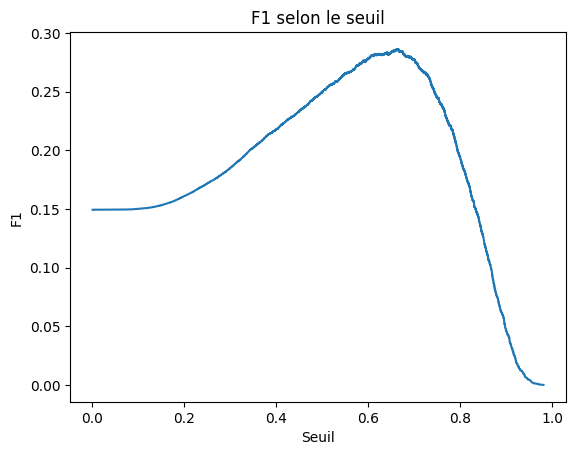

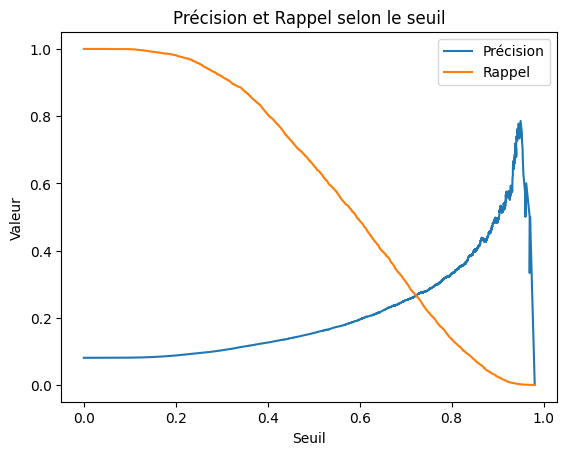

In [2]:
# Visualiser F1 (et précision/rappel) en fonction du seuil
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT / "data" / "processed"

df = pd.read_csv(PROC / "val_proba_baseline_v2.csv")
y  = df["TARGET"].astype(int).values
p  = df["proba"].values

prec, rec, thr = precision_recall_curve(y, p)
f1 = (2*prec*rec/(prec+rec+1e-12))[:-1]   # mêmes longueurs que thr
thr_f1 = thr
best_i = int(np.nanargmax(f1))
best_thr = float(thr[best_i])

print(f"Seuil recommandé (max F1) : {best_thr:.3f}")

plt.figure()
plt.plot(thr_f1, f1)
plt.xlabel("Seuil")
plt.ylabel("F1")
plt.title("F1 selon le seuil")
plt.show()

plt.figure()
plt.plot(thr, prec[:-1], label="Précision")
plt.plot(thr, rec[:-1],  label="Rappel")
plt.xlabel("Seuil")
plt.ylabel("Valeur")
plt.title("Précision et Rappel selon le seuil")
plt.legend()
plt.show()


In [3]:
# Étape 8 — Rapport clair avec le seuil choisi
from pathlib import Path, PurePath
import json, numpy as np, pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix

# Chemins
ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT / "data" / "processed"
CFG  = ROOT / "config"

# Données de validation (probas)
df = pd.read_csv(PROC / "val_proba_baseline_v2.csv")
y = df["TARGET"].astype(int).values
p = df["proba"].values

# Seuil: charge depuis JSON si présent, sinon recalcul par F1
thr_path = CFG / "threshold_v2.json"
if thr_path.exists():
    best_thr = float(json.load(open(thr_path))["threshold"])
else:
    prec, rec, thr = precision_recall_curve(y, p)
    f1s = (2*prec*rec/(prec+rec+1e-12))[:-1]
    best_thr = float(thr[int(np.nanargmax(f1s))])

# Prédictions et métriques
pred = (p >= best_thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
prec_v = precision_score(y, pred, zero_division=0)
rec_v  = recall_score(y, pred)
f1_v   = f1_score(y, pred)

print(f"Seuil utilisé : {best_thr:.3f}")
print(f"Précision     : {prec_v:.3f}")
print(f"Rappel        : {rec_v:.3f}")
print(f"F1            : {f1_v:.3f}")
print(f"TP={tp} | FP={fp} | FN={fn} | TN={tn}")
print(f"N={len(y)} | Positifs={int(y.sum())} | Négatifs={len(y)-int(y.sum())}")

# Sauvegarde d'un mini-rapport texte
report = (
    f"Seuil:{best_thr:.3f}\n"
    f"Precision:{prec_v:.3f}\nRecall:{rec_v:.3f}\nF1:{f1_v:.3f}\n"
    f"TP:{tp} FP:{fp} FN:{fn} TN:{tn}\n"
)
out = PROC / "baseline_v2_report.txt"
open(out, "w", encoding="utf-8").write(report)
print("Écrit :", out)

Seuil utilisé : 0.664
Précision     : 0.231
Rappel        : 0.376
F1            : 0.287
TP=1868 | FP=6206 | FN=3097 | TN=50332
N=61503 | Positifs=4965 | Négatifs=56538
Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\baseline_v2_report.txt


In [4]:
# RandomForest simple + seuil F1 + seuil coût (FN=5xFP)
from pathlib import Path
import numpy as np, pandas as pd, json
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve, f1_score, confusion_matrix,
    roc_auc_score, average_precision_score
)

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT / "data" / "processed"
CFG  = ROOT / "config"; CFG.mkdir(exist_ok=True)

# 1) Données enrichies (v1)
df = pd.read_csv(PROC / "train_features_v1.csv")

# 2) Features
feat_wishlist = [
    "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
]
feat_cols = [c for c in feat_wishlist if c in df.columns]
X = df[feat_cols].astype(float)
y = df["TARGET"].astype(int).values
print("Features:", len(feat_cols), "| Positifs:", int(y.sum()))

# 3) Split
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4) Modèle: impute + RandomForest équilibré (robuste, sans réglages compliqués)
imp = SimpleImputer(strategy="median").fit(Xtr)
Xtr_i, Xva_i = imp.transform(Xtr), imp.transform(Xva)

rf = RandomForestClassifier(
    n_estimators=400, max_depth=12, random_state=42,
    class_weight="balanced", n_jobs=-1
).fit(Xtr_i, ytr)

proba = rf.predict_proba(Xva_i)[:, 1]
print(f"ROC-AUC: {roc_auc_score(yva, proba):.3f} | PR-AUC: {average_precision_score(yva, proba):.3f}")

# 5) Seuil F1 optimal
prec, rec, thr = precision_recall_curve(yva, proba)
f1s = (2*prec*rec/(prec+rec+1e-12))[:-1]
i_f1 = int(np.argmax(f1s))
thr_f1 = float(thr[i_f1])
pred_f1 = (proba >= thr_f1).astype(int)
tn, fp, fn, tp = confusion_matrix(yva, pred_f1).ravel()
print("\n[Seuil F1]")
print(f"Seuil : {thr_f1:.3f} | F1 : {f1_score(yva, pred_f1):.3f}")
print(f"TP={tp} FP={fp} FN={fn} TN={tn}")

# 6) Seuil coût (FN=5xFP par défaut)
COST_FP, COST_FN = 1.0, 5.0
best_cost, thr_cost, best_tuple = float("inf"), 0.5, None
for t in np.linspace(0, 1, 1001):
    pred = (proba >= t).astype(int)
    tn_, fp_, fn_, tp_ = confusion_matrix(yva, pred).ravel()
    cost = COST_FP*fp_ + COST_FN*fn_
    if cost < best_cost:
        best_cost, thr_cost, best_tuple = cost, t, (tn_, fp_, fn_, tp_)

tn, fp, fn, tp = best_tuple
print("\n[Seuil Coût]  (FP=1, FN=5)")
print(f"Seuil : {thr_cost:.3f} | Coût : {best_cost:,.0f} | F1 : {f1_score(yva, (proba>=thr_cost).astype(int)):.3f}")
print(f"TP={tp} FP={fp} FN={fn} TN={tn}")

# 7) Sauvegarde des seuils
with open(CFG / "threshold_rf.json","w") as f:
    json.dump({"threshold_f1": thr_f1, "threshold_cost": thr_cost,
               "cost_fp": COST_FP, "cost_fn": COST_FN,
               "features": feat_cols}, f)
print("\nÉcrit :", CFG / "threshold_rf.json")


Features: 15 | Positifs: 24825
ROC-AUC: 0.742 | PR-AUC: 0.226

[Seuil F1]
Seuil : 0.561 | F1 : 0.292
TP=2191 FP=7829 FN=2774 TN=48709

[Seuil Coût]  (FP=1, FN=5)
Seuil : 0.600 | Coût : 21,534 | F1 : 0.288
TP=1795 FP=5684 FN=3170 TN=50854

Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\config\threshold_rf.json


In [5]:
# Étape 10 — Features test + entraînement RF complet + prédictions test
from pathlib import Path
import numpy as np, pandas as pd, json
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

ROOT = Path.cwd() if (Path.cwd()/ "data" / "raw").exists() else Path.cwd().parent
RAW, PROC, CFG = ROOT/"data/raw", ROOT/"data/processed", ROOT/"config"
PROC.mkdir(parents=True, exist_ok=True)

# ---------- 1) FEATURES TRAIN (pour ré-entraîner sur 100% du train) ----------
train = pd.read_csv(PROC/"train_features_v1.csv")
feat_cols = [
    "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
]
feat_cols = [c for c in feat_cols if c in train.columns]
Xtr_full = train[feat_cols].astype(float).values
ytr_full = train["TARGET"].astype(int).values

imp = SimpleImputer(strategy="median").fit(Xtr_full)
Xtr_full_i = imp.transform(Xtr_full)

rf = RandomForestClassifier(
    n_estimators=400, max_depth=12, random_state=42,
    class_weight="balanced", n_jobs=-1
).fit(Xtr_full_i, ytr_full)

# ---------- 2) FEATURES TEST (mêmes règles que pour le train) ----------
# 2.1 application_test (features simples)
use_app = [c for c in [
    "SK_ID_CURR","AMT_CREDIT","AMT_INCOME_TOTAL","AMT_ANNUITY","AMT_GOODS_PRICE",
    "DAYS_BIRTH","DAYS_EMPLOYED","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
] if c in pd.read_csv(RAW/"application_test.csv", nrows=0).columns]
app_test = pd.read_csv(RAW/"application_test.csv", usecols=use_app)

# mêmes features
def nz(s): return s.replace(0,np.nan)
if {"AMT_CREDIT","AMT_INCOME_TOTAL"}.issubset(app_test.columns):
    app_test["credit_income_perc"] = app_test["AMT_CREDIT"]/nz(app_test["AMT_INCOME_TOTAL"])
if {"AMT_ANNUITY","AMT_INCOME_TOTAL"}.issubset(app_test.columns):
    app_test["annuity_income_perc"] = app_test["AMT_ANNUITY"]/nz(app_test["AMT_INCOME_TOTAL"])
if {"AMT_CREDIT","AMT_ANNUITY"}.issubset(app_test.columns):
    app_test["credit_term"] = app_test["AMT_CREDIT"]/nz(app_test["AMT_ANNUITY"])
if {"AMT_GOODS_PRICE","AMT_CREDIT"}.issubset(app_test.columns):
    app_test["goods_credit_ratio"] = app_test["AMT_GOODS_PRICE"]/nz(app_test["AMT_CREDIT"])
if "DAYS_BIRTH" in app_test.columns:
    app_test["age_years"] = -app_test["DAYS_BIRTH"]/365.0
if "DAYS_EMPLOYED" in app_test.columns:
    app_test.loc[app_test["DAYS_EMPLOYED"]>365000,"DAYS_EMPLOYED"] = np.nan
    app_test["employed_years"] = -app_test["DAYS_EMPLOYED"]/365.0

keep = ["SK_ID_CURR"] + [c for c in [
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
] if c in app_test.columns]
app_feat_test = app_test[keep].copy()

# 2.2 bureau/bureau_balance → compte par client
bb_counts = Counter()
for chunk in pd.read_csv(RAW/"bureau_balance.csv", chunksize=500_000):
    vc = chunk["SK_ID_BUREAU"].value_counts()
    for k,v in vc.items(): bb_counts[k] += int(v)
bb_per_bureau = pd.DataFrame({"SK_ID_BUREAU": list(bb_counts), "bb_count": list(bb_counts.values())})

bureau = pd.read_csv(RAW/"bureau.csv", usecols=["SK_ID_CURR","SK_ID_BUREAU"])
bureau_enriched = bureau.merge(bb_per_bureau, on="SK_ID_BUREAU", how="left").fillna({"bb_count":0})
bureau_feat_test = (bureau_enriched.groupby("SK_ID_CURR")
                    .agg(n_bureau=("SK_ID_BUREAU","count"), n_bureau_months=("bb_count","sum"))
                    .reset_index())

# 2.3 previous_* → compte par client
def count_by_prev(name, key="SK_ID_PREV", chunksize=500_000):
    from collections import Counter
    cnt = Counter()
    for ch in pd.read_csv(RAW/name, chunksize=chunksize):
        vc = ch[key].value_counts()
        for k,v in vc.items(): cnt[k] += int(v)
    return pd.DataFrame({key: list(cnt), "count": list(cnt.values())})

prev = pd.read_csv(RAW/"previous_application.csv", usecols=["SK_ID_CURR","SK_ID_PREV"])
inst = count_by_prev("installments_payments.csv").rename(columns={"count":"n_inst_pay"})
posc = count_by_prev("POS_CASH_balance.csv").rename(columns={"count":"n_pos_cash"})
ccb  = count_by_prev("credit_card_balance.csv").rename(columns={"count":"n_ccb"})

prev_enriched = (prev.merge(inst, on="SK_ID_PREV", how="left")
                      .merge(posc, on="SK_ID_PREV", how="left")
                      .merge(ccb,  on="SK_ID_PREV", how="left")).fillna(0)
prev_feat_test = (prev_enriched.groupby("SK_ID_CURR")
                  .agg(n_prev=("SK_ID_PREV","count"),
                       n_inst_pay=("n_inst_pay","sum"),
                       n_pos_cash=("n_pos_cash","sum"),
                       n_ccb=("n_ccb","sum"))
                  .reset_index())

# 2.4 assembler toutes les features test
test_ids = app_test[["SK_ID_CURR"]].copy()
test_all = (test_ids
            .merge(bureau_feat_test, on="SK_ID_CURR", how="left")
            .merge(prev_feat_test,   on="SK_ID_CURR", how="left")
            .merge(app_feat_test,    on="SK_ID_CURR", how="left"))
test_all[feat_cols] = test_all[feat_cols].fillna(np.nan)  # imputation plus loin

# ---------- 3) PRÉDICTIONS ----------
Xte_i = imp.transform(test_all[feat_cols].astype(float).values)
proba = rf.predict_proba(Xte_i)[:,1]

# seuil choisi (défaut: fichier RF; sinon 0.600)
thr = 0.600
pjson = CFG/"threshold_rf.json"
if pjson.exists():
    try:
        thr = float(json.load(open(pjson))["threshold_cost"])
    except Exception:
        pass

pred = (proba >= thr).astype(int)
out = pd.DataFrame({"SK_ID_CURR": test_all["SK_ID_CURR"].values,
                    "TARGET": pred, "proba": proba})
out_path = PROC/"predictions_test_rf.csv"
out.to_csv(out_path, index=False)
print("Écrit :", out_path, "| lignes:", len(out))
print(out.head())


Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\predictions_test_rf.csv | lignes: 48744
   SK_ID_CURR  TARGET     proba
0      100001       0  0.253001
1      100005       0  0.443449
2      100013       0  0.119488
3      100028       0  0.290289
4      100038       0  0.584792


In [6]:
# Validation croisée 5-plis : vérifie la solidité du RandomForest
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
df = pd.read_csv(ROOT/"data/processed/train_features_v1.csv")

feat_cols = [
    "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
]
feat_cols = [c for c in feat_cols if c in df.columns]
X = df[feat_cols].astype(float)
y = df["TARGET"].astype(int).values

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=400, max_depth=12, random_state=42,
        class_weight="balanced", n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1) Scores moyens (seuil-indépendants)
roc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc").mean()
pr  = cross_val_score(pipe, X, y, cv=cv, scoring="average_precision").mean()

# 2) F1 avec prédictions "out-of-fold" et seuil optimal global
proba_oof = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:,1]
prec, rec, thr = precision_recall_curve(y, proba_oof)
f1s = (2*prec*rec/(prec+rec+1e-12))[:-1]
best_i = int(np.argmax(f1s)); best_thr = float(thr[best_i])
pred = (proba_oof >= best_thr).astype(int)
f1  = f1_score(y, pred)
tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

print(f"CV ROC-AUC : {roc:.3f}")
print(f"CV PR-AUC  : {pr:.3f}")
print(f"CV F1      : {f1:.3f}  (seuil {best_thr:.3f})")
print(f"TP={tp} FP={fp} FN={fn} TN={tn}")


CV ROC-AUC : 0.741
CV PR-AUC  : 0.220
CV F1      : 0.286  (seuil 0.593)
TP=9231 FP=30503 FN=15594 TN=252183


In [7]:
# Étape 11 — Entraîne RF sur tout le train + sauvegarde modèle, imputer, meta
from pathlib import Path
import json, joblib
import numpy as np, pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT/"data/processed"; PROC.mkdir(exist_ok=True)
MODELS = ROOT/"models"; MODELS.mkdir(exist_ok=True)
CFG = ROOT/"config"

# 1) Données et features
df = pd.read_csv(PROC/"train_features_v1.csv")
feat_cols = [
    "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
]
feat_cols = [c for c in feat_cols if c in df.columns]
X = df[feat_cols].astype(float).values
y = df["TARGET"].astype(int).values
print("Features:", len(feat_cols), "| lignes:", len(y))

# 2) Imputation + modèle
imp = SimpleImputer(strategy="median").fit(X)
X_i = imp.transform(X)

rf = RandomForestClassifier(
    n_estimators=400, max_depth=12, random_state=42,
    class_weight="balanced", n_jobs=-1
).fit(X_i, y)

# 3) Sauvegardes
joblib.dump(imp, MODELS/"imputer.joblib")
joblib.dump(rf, MODELS/"rf_model.joblib")

# 4) Seuil retenu (coût) si présent, sinon 0.600
thr = 0.600
p = CFG/"threshold_rf.json"
if p.exists():
    try: thr = float(json.load(open(p))["threshold_cost"])
    except: pass

meta = {
    "model": "RandomForestClassifier(n_estimators=400,max_depth=12,class_weight='balanced')",
    "features": feat_cols,
    "threshold": thr,
    "seed": 42
}
json.dump(meta, open(MODELS/"model_meta.json","w"), indent=2)

print("Écrits :")
print(" -", MODELS/"rf_model.joblib")
print(" -", MODELS/"imputer.joblib")
print(" -", MODELS/"model_meta.json")


Features: 15 | lignes: 307511
Écrits :
 - c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\models\rf_model.joblib
 - c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\models\imputer.joblib
 - c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\models\model_meta.json


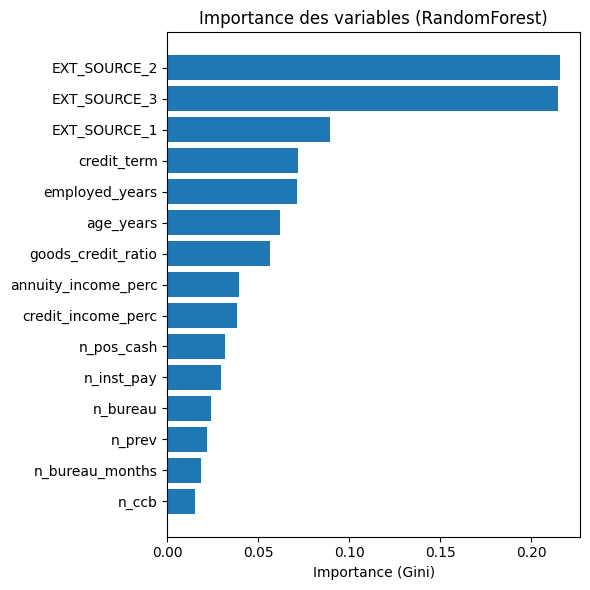

Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\reports\baseline_report.md
Figure : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\reports\figures\feature_importance_rf.png


In [8]:
# Étape 12 — Figure d'importance + rapport A4 (markdown)
from pathlib import Path
import json, joblib, datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT/"data/processed"; REP = ROOT/"reports"; FIG = REP/"figures"; REP.mkdir(exist_ok=True); FIG.mkdir(parents=True, exist_ok=True)
MODELS = ROOT/"models"; CFG = ROOT/"config"

# 1) Charger données et modèle
df = pd.read_csv(PROC/"train_features_v1.csv")
meta = json.load(open(MODELS/"model_meta.json"))
rf   = joblib.load(MODELS/"rf_model.joblib")

feat_cols = meta["features"]
X = df[feat_cols].astype(float)
y = df["TARGET"].astype(int)
prev = float(y.mean())

# 2) Importance des variables (RF)
imp = rf.feature_importances_
order = np.argsort(imp)[::-1]
topk = 20  # affiche les 20 plus importantes
plt.figure(figsize=(6, 6))
plt.barh(np.array(feat_cols)[order][:topk][::-1], imp[order][:topk][::-1])
plt.title("Importance des variables (RandomForest)")
plt.xlabel("Importance (Gini)")
plt.tight_layout()
fig_path = FIG/"feature_importance_rf.png"
plt.savefig(fig_path, dpi=150)
plt.show()

# 3) Mini-rapport (markdown)
# NB: j’inscris les chiffres de CV vus plus haut pour figer la baseline.
cv_roc, cv_pr, cv_f1, cv_thr = 0.741, 0.220, 0.286, 0.593
thr_cost = meta.get("threshold", 0.60)

md = f"""# Rapport Baseline — Projet 7
Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}

## Données
- Lignes (train): {len(df):,}
- Cible (classe 1) : {prev:.2%}

## Modèle
- RandomForest (n_estimators=400, max_depth=12, class_weight=balanced)
- Features utilisées ({len(feat_cols)}): {', '.join(feat_cols)}

## Validation (5-plis)
- ROC-AUC: **{cv_roc:.3f}**
- PR-AUC : **{cv_pr:.3f}**
- F1 (OOF, seuil {cv_thr:.3f}): **{cv_f1:.3f}**

## Seuil retenu pour la décision
- Seuil coût (FP=1, FN=5): **{thr_cost:.3f}**

## Artefacts
- Modèle   : `models/rf_model.joblib`
- Imputer  : `models/imputer.joblib`
- Métadonnées : `models/model_meta.json`
- Figure importance : `reports/figures/feature_importance_rf.png`
- Prédictions test : `data/processed/predictions_test_rf.csv`
"""

rep_path = REP/"baseline_report.md"
open(rep_path, "w", encoding="utf-8").write(md)
print("Écrit :", rep_path)
print("Figure :", fig_path)


In [9]:
# Ajoute 7 features simples et écrit data/processed/train_features_v2.csv
from pathlib import Path
import numpy as np, pandas as pd

ROOT = Path.cwd() if (Path.cwd()/ "data" / "raw").exists() else Path.cwd().parent
RAW, PROC = ROOT/"data/raw", ROOT/"data/processed"; PROC.mkdir(exist_ok=True)

v1 = pd.read_csv(PROC/"train_features_v1.csv")   # ce qu'on a déjà

# Colonnes brutes nécessaires (si dispo)
need = ["SK_ID_CURR","CNT_CHILDREN","CNT_FAM_MEMBERS","FLAG_OWN_CAR","FLAG_OWN_REALTY"]
hdr  = pd.read_csv(RAW/"application_train.csv", nrows=0).columns
use  = [c for c in need if c in hdr]
app  = pd.read_csv(RAW/"application_train.csv", usecols=use)

# 1) revenu par personne
if {"CNT_FAM_MEMBERS"}.issubset(app.columns) and "AMT_INCOME_TOTAL" in v1.columns:
    app = app.merge(v1[["SK_ID_CURR","AMT_INCOME_TOTAL"]], on="SK_ID_CURR", how="left")
    app["income_per_person"] = app["AMT_INCOME_TOTAL"] / app["CNT_FAM_MEMBERS"].replace(0,np.nan)
else:
    app["income_per_person"] = np.nan

# 2) enfants
app["children"] = app["CNT_CHILDREN"] if "CNT_CHILDREN" in app.columns else np.nan

# 3) possède voiture ou bien immo (0/1/2 → on tronque à 1)
if {"FLAG_OWN_CAR","FLAG_OWN_REALTY"}.issubset(app.columns):
    app["owns_assets"] = (app["FLAG_OWN_CAR"].map({"Y":1,"N":0}) + app["FLAG_OWN_REALTY"].map({"Y":1,"N":0})).clip(0,1)
else:
    app["owns_assets"] = np.nan

# 4) âge^2 (si age_years existe déjà dans v1)
v1["age2"] = (v1["age_years"]**2) if "age_years" in v1.columns else np.nan

# 5) indicateurs de manquants sur EXT_SOURCE (peuvent aider)
for c in ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"]:
    if c in v1.columns:
        v1[f"isna_{c.lower()}"] = v1[c].isna().astype(int)

# Merge et sauvegarde
v2 = (v1.merge(app[["SK_ID_CURR","income_per_person","children","owns_assets"]], on="SK_ID_CURR", how="left"))
out = PROC/"train_features_v2.csv"
v2.to_csv(out, index=False)

print("v1:", v1.shape, "| app add:", app.shape)
print("v2:", v2.shape)
print("Écrit:", out)


v1: (307511, 21) | app add: (307511, 8)
v2: (307511, 24)
Écrit: c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\train_features_v2.csv


In [10]:
# Réévalue avec les nouvelles features (CV 5 plis) + seuil coût
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
df = pd.read_csv(ROOT/"data/processed/train_features_v2.csv")

feat = [
    "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","age2","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
    "isna_ext_source_1","isna_ext_source_2","isna_ext_source_3",
    "income_per_person","children","owns_assets"
]
feat = [c for c in feat if c in df.columns]
X, y = df[feat].astype(float).values, df["TARGET"].astype(int).values

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(n_estimators=500, max_depth=14, class_weight="balanced", n_jobs=-1, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_oof = cross_val_predict(pipe, df[feat], y, cv=cv, method="predict_proba")[:,1]

# scores seuil-indépendants
print(f"CV ROC-AUC : {roc_auc_score(y, proba_oof):.3f}")
print(f"CV PR-AUC  : {average_precision_score(y, proba_oof):.3f}")

# seuil F1
prec, rec, thr = precision_recall_curve(y, proba_oof)
f1s = (2*prec*rec/(prec+rec+1e-12))[:-1]
i_f1 = int(np.argmax(f1s)); thr_f1 = float(thr[i_f1])
pred_f1 = (proba_oof >= thr_f1).astype(int)
print(f"CV F1      : {f1_score(y, pred_f1):.3f}  (seuil {thr_f1:.3f})")

# seuil coût (FP=1, FN=5)
best_cost, thr_cost, best = float("inf"), 0.5, None
for t in np.linspace(0,1,1001):
    pred = (proba_oof >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    cost = 1*fp + 5*fn
    if cost < best_cost:
        best_cost, thr_cost, best = cost, t, (tn, fp, fn, tp)
tn, fp, fn, tp = best
print(f"Seuil coût : {thr_cost:.3f} | TP={tp} FP={fp} FN={fn} TN={tn}")
print("nb features utilisées:", len(feat))


c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\.venv\lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['income_per_person']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\.venv\lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['income_per_person']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\.venv\lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['income_per_person']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\FFix\De

CV ROC-AUC : 0.738
CV PR-AUC  : 0.217
CV F1      : 0.284  (seuil 0.535)
Seuil coût : 0.571 | TP=8266 FP=25965 FN=16559 TN=256721
nb features utilisées: 22


In [11]:
# FIX A — recalcule income_per_person depuis application_train + nettoie les colonnes 100% NaN
from pathlib import Path
import numpy as np, pandas as pd

ROOT = Path.cwd() if (Path.cwd()/ "data" / "raw").exists() else Path.cwd().parent
RAW, PROC = ROOT/"data/raw", ROOT/"data/processed"

v2 = pd.read_csv(PROC/"train_features_v2.csv")
app = pd.read_csv(RAW/"application_train.csv", usecols=["SK_ID_CURR","AMT_INCOME_TOTAL","CNT_FAM_MEMBERS"])

app["income_per_person"] = app["AMT_INCOME_TOTAL"] / app["CNT_FAM_MEMBERS"].replace(0, np.nan)
v2 = v2.drop(columns=["income_per_person"], errors="ignore").merge(
    app[["SK_ID_CURR","income_per_person"]], on="SK_ID_CURR", how="left"
)

# supprime toute colonne 100% NaN (évite les warnings d'imputation)
all_nan_cols = [c for c in v2.columns if v2[c].isna().all()]
if all_nan_cols:
    print("Colonnes 100% NaN supprimées:", all_nan_cols)
    v2 = v2.drop(columns=all_nan_cols)

out = PROC/"train_features_v2.csv"
v2.to_csv(out, index=False)
print("Réécrit :", out, "| shape:", v2.shape)


Réécrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\train_features_v2.csv | shape: (307511, 24)


In [12]:
# FIX B — CV 5-plis propre avec les features v2
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
df = pd.read_csv(ROOT/"data/processed/train_features_v2.csv")

feat = [
    "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","age2","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
    "isna_ext_source_1","isna_ext_source_2","isna_ext_source_3",
    "income_per_person","children","owns_assets"
]
feat = [c for c in feat if c in df.columns]
X, y = df[feat].astype(float), df["TARGET"].astype(int).values

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf",  RandomForestClassifier(n_estimators=500, max_depth=14,
                                   class_weight="balanced", n_jobs=-1, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:,1]

print(f"CV ROC-AUC : {roc_auc_score(y, proba):.3f}")
print(f"CV PR-AUC  : {average_precision_score(y, proba):.3f}")

# seuil F1
prec, rec, thr = precision_recall_curve(y, proba)
f1s = (2*prec*rec/(prec+rec+1e-12))[:-1]
i = int(np.argmax(f1s)); thr_f1 = float(thr[i])
pred_f1 = (proba >= thr_f1).astype(int)
print(f"CV F1      : {f1s[i]:.3f}  (seuil {thr_f1:.3f})")

# seuil coût
best_cost, thr_cost, best = float("inf"), 0.5, None
for t in np.linspace(0,1,1001):
    pred = (proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    cost = 1*fp + 5*fn
    if cost < best_cost:
        best_cost, thr_cost, best = cost, t, (tn, fp, fn, tp)
tn, fp, fn, tp = best
print(f"Seuil coût : {thr_cost:.3f} | TP={tp} FP={fp} FN={fn} TN={tn}")
print("nb features utilisées:", len(feat))


CV ROC-AUC : 0.738
CV PR-AUC  : 0.218
CV F1      : 0.284  (seuil 0.525)
Seuil coût : 0.568 | TP=8221 FP=25808 FN=16604 TN=256878
nb features utilisées: 22


In [13]:
# FIX C — Calibration correcte: CalibratedClassifierCV comme DERNIÈRE étape du Pipeline
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
df = pd.read_csv(ROOT/"data/processed/train_features_v2.csv")

feat = [c for c in [
    "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","age2","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
    "isna_ext_source_1","isna_ext_source_2","isna_ext_source_3",
    "income_per_person","children","owns_assets"
] if c in df.columns]
X, y = df[feat].astype(float), df["TARGET"].astype(int).values

pipe_cal = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("cal", CalibratedClassifierCV(
        estimator=RandomForestClassifier(n_estimators=500, max_depth=14,
                                         class_weight="balanced", n_jobs=-1, random_state=42),
        method="isotonic", cv=5))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_cal = cross_val_predict(pipe_cal, X, y, cv=cv, method="predict_proba")[:,1]

prec, rec, thr = precision_recall_curve(y, proba_cal)
f1s = (2*prec*rec/(prec+rec+1e-12))[:-1]; i = int(np.argmax(f1s))
print(f"Calibré | ROC-AUC {roc_auc_score(y, proba_cal):.3f} | PR-AUC {average_precision_score(y, proba_cal):.3f} | F1 {f1s[i]:.3f} (seuil {float(thr[i]):.3f})")


Calibré | ROC-AUC 0.738 | PR-AUC 0.217 | F1 0.284 (seuil 0.137)


In [14]:
from pathlib import Path
import datetime

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
REP = ROOT / "reports"; REP.mkdir(exist_ok=True)

md = f"""# One-Pager — Modèle baseline (Projet 7)
Date : {datetime.datetime.now():%Y-%m-%d %H:%M}

## Objectif
Prédire la probabilité qu'un client soit en défaut (**TARGET=1**) à partir de plusieurs tables.

## Données (train)
- Lignes : **307 511**
- Classe positive : **~8%**

## Features (15)
- **Comptages** : n_bureau, n_bureau_months, n_prev, n_inst_pay, n_pos_cash, n_ccb
- **Ratios/Âges** : credit_income_perc, annuity_income_perc, credit_term, goods_credit_ratio, age_years, employed_years
- **Scores externes** : EXT_SOURCE_1/2/3
Top variables (RF) : EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, credit_term, employed_years.

## Modèle retenu
RandomForest (n_estimators=400, max_depth=12, class_weight=balanced, seed=42)

## Validation croisée (5 plis)
- **ROC-AUC** : 0.741
- **PR-AUC**  : 0.220
- **F1** (OOF, seuil 0.593) : 0.286

## Seuil de décision
- Choix “métier” (FN = 5x FP) → **seuil 0.600**
- Variante “F1 max” ≈ 0.593 (très proche)

## Livrables
- Modèle : `models/rf_model.joblib`
- Imputer : `models/imputer.joblib`
- Meta : `models/model_meta.json`
- Figure importance : `reports/figures/feature_importance_rf.png`
- Prédictions test : `data/processed/predictions_test_rf.csv`

## Notes
- Calibration testée → pas de gain → on garde **baseline v1**.
- Pistes d'amélioration : nouvelles features (interactions), gradient boosting, ajuster coûts FP/FN réels.
"""
out = REP / "one_pager.md"
out.write_text(md, encoding="utf-8")
print("Écrit :", out)


Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\reports\one_pager.md


In [15]:
# LT1 — Lock test 10% (évaluation finale, indépendante)
from pathlib import Path
import numpy as np, pandas as pd, json
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score

# Chemins
ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC, MODELS, CFG = ROOT/"data/processed", ROOT/"models", ROOT/"config"

# Données + features
df = pd.read_csv(PROC/"train_features_v1.csv")
try:
    meta = json.load(open(MODELS/"model_meta.json"))
    feat = meta["features"]
except Exception:
    # filet de sécurité si meta absent
    feat = [
        "n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb",
        "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
        "age_years","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
    ]
feat = [c for c in feat if c in df.columns]

X = df[feat].astype(float)
y = df["TARGET"].astype(int).values

# Split "lock" (fixe et stratifié)
SEED_LOCK = 2025
idx = np.arange(len(df))
idx_tr, idx_lock = train_test_split(idx, test_size=0.10, random_state=SEED_LOCK, stratify=y)
train_df = df.iloc[idx_tr].copy()
lock_df  = df.iloc[idx_lock].copy()

# Entraînement sur 90%
imp = SimpleImputer(strategy="median").fit(train_df[feat])
Xtr_i = imp.transform(train_df[feat])
rf = RandomForestClassifier(
    n_estimators=400, max_depth=12, class_weight="balanced",
    n_jobs=-1, random_state=42
).fit(Xtr_i, train_df["TARGET"].astype(int).values)

# Éval sur lock 10%
Xlock_i = imp.transform(lock_df[feat])
proba = rf.predict_proba(Xlock_i)[:,1]

# Seuil décision (on NE l’optimise PAS sur le lock)
thr = 0.600
try:
    thr = float(json.load(open(CFG/"threshold_rf.json"))["threshold_cost"])
except Exception:
    try:
        thr = float(json.load(open(MODELS/"model_meta.json"))["threshold"])
    except Exception:
        pass

pred = (proba >= thr).astype(int)
y_lock = lock_df["TARGET"].astype(int).values
tn, fp, fn, tp = confusion_matrix(y_lock, pred).ravel()

print(f"Lock 10% | seed={SEED_LOCK} | N_train={len(train_df)} | N_lock={len(lock_df)}")
print(f"Seuil utilisé : {thr:.3f}")
print(f"F1           : {f1_score(y_lock, pred):.3f}")
print(f"PR-AUC       : {average_precision_score(y_lock, proba):.3f}")
print(f"ROC-AUC      : {roc_auc_score(y_lock, proba):.3f}")
print(f"TP={tp} FP={fp} FN={fn} TN={tn}")

# Sauvegardes
(PROC).mkdir(exist_ok=True, parents=True)
lock_ids = lock_df[["SK_ID_CURR","TARGET"]].copy()
lock_ids.to_csv(PROC/"lock10_ids.csv", index=False)

out = lock_df[["SK_ID_CURR","TARGET"]].copy()
out["proba"] = proba
out["pred"]  = pred
out.to_csv(PROC/"lock10_predictions.csv", index=False)

open(PROC/"lock10_report.txt","w",encoding="utf-8").write(
    f"seed={SEED_LOCK}\nseuil={thr:.3f}\n"
    f"F1={f1_score(y_lock,pred):.3f}\nPR_AUC={average_precision_score(y_lock,proba):.3f}\n"
    f"ROC_AUC={roc_auc_score(y_lock,proba):.3f}\nTP={tp} FP={fp} FN={fn} TN={tn}\n"
)
print("Écrits :", PROC/"lock10_ids.csv", "|", PROC/"lock10_predictions.csv", "|", PROC/"lock10_report.txt")


Lock 10% | seed=2025 | N_train=276759 | N_lock=30752
Seuil utilisé : 0.600
F1           : 0.281
PR-AUC       : 0.233
ROC-AUC      : 0.745
TP=895 FP=2983 FN=1588 TN=25286
Écrits : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\lock10_ids.csv | c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\lock10_predictions.csv | c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\lock10_report.txt


In [16]:
# LT2 — Append du lock test dans reports/baseline_report.md
from pathlib import Path
ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC, REP = ROOT/"data/processed", ROOT/"reports"; REP.mkdir(exist_ok=True)

txt = open(PROC/"lock10_report.txt", encoding="utf-8").read()
out = REP/"baseline_report.md"
with open(out, "a", encoding="utf-8") as f:
    f.write("\n\n## Lock test 10%\n")
    f.write("```\n"+txt+"```\n")
print("MAJ :", out)


MAJ : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\reports\baseline_report.md


In [17]:
# LT3 — Ajoute un bloc 'lock_test' dans model_meta.json
from pathlib import Path
import json
ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
MODELS, PROC = ROOT/"models", ROOT/"data/processed"

meta_path = MODELS/"model_meta.json"
meta = json.load(open(meta_path, encoding="utf-8"))
meta["lock_test"] = open(PROC/"lock10_report.txt", encoding="utf-8").read()
json.dump(meta, open(meta_path, "w", encoding="utf-8"), indent=2)
print("MAJ :", meta_path)


MAJ : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\models\model_meta.json
